**Домашнее задание №2**

Дедлайн: __21 марта 2025 года__

В этом домашнем задании закрепим знания по работе с библиотекой __pytorch-lifestream__ для задачи предсказания бакета возраста клиента по транзакционнным данным клиента.

Работа состоит из __четырех частей__:

__1. EDA данных - 3 балла__

На этом этапе необходимо проанализировать данные по транзакциям и целевой переменной, сформулировать гипотезы для проверки их на этапе моделирования.
Также стоит попробовать сформировать немодельный baseline (например, предсказание самого популярного бакета) и зафиксировать метрики для такого бейзлайна.

__2. Бейзлайн - 3 балла__

На этом этапе формируем "ручные" агрегатные признаки по транзакционным данным и строим на их основе _multiclass модель:_ логистическая регрессия либо градиентный бустинг. В этой части стоит уделить внимание генерации "ручных" признаков и подбору гиперпараметров модели.

__3. Обучение эмбеддингов над транзакциями - 3 балла__

По аналогии с семинаром, нужно обучить транзакционные эмбеддинги при помощи библиотеки __pytorch-lifestream__. Обученные эмбеддинги стоит использовать как доп. признаки, которые стоит докинуть в бейзлайн п.2. В этой части стоит поварьировать несколько гиперпараметров для обучения эмбеддингов: тип энкодера, уроверь зашумления эмбеддингов, количество эпох для обучения алгоритма.

__4. Выводы по итогам моделирования - 1 балл__

In [ ]:
import pandas as pd

### 1.EDA данных - **[3 балла]**

На этом этапе необходимо проанализировать данные для моделирования и ответить на __вопросы:__

1) Какое распределение имеет таргет (есть ли дисбаланс даннных)?

2) Есть ли проблемы с данными по целевой переменной и транзакциям (пропуски/выбросы)?

3) Нужно ли делать доп. преобразования признаков/таргета для улучшения качества моделирования?

4) Какие "ручные" признаки стоит сгенерировать для модели этапа 2?

In [ ]:
%%time
# загружаем данные
source_data = pd.read_csv("hf://datasets/dllllb/age-group-prediction/transactions_train.csv.gz")
df_target = pd.read_csv("hf://datasets/dllllb/age-group-prediction/train_target.csv")

# оставим только 10_000 клиентов
random_client_id = list(set(source_data['client_id'].unique()))[:2_000] # возьмем только 5_000 ID
source_data = source_data[source_data['client_id'].isin(random_client_id)]
df_target = df_target[df_target['client_id'].isin(random_client_id)]

CPU times: user 9.78 s, sys: 700 ms, total: 10.5 s
Wall time: 19 s


Код по EDA приводите в ячейках ниже:

#### 1) Какое распределение имеет таргет (есть ли дисбаланс даннных)?

In [ ]:
df_target['bins'].value_counts()

,count
bins,
2,524
3,515
1,490
0,471


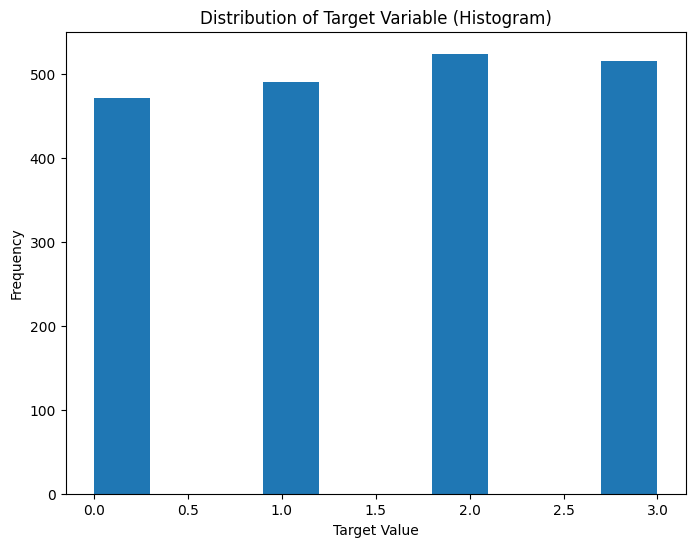

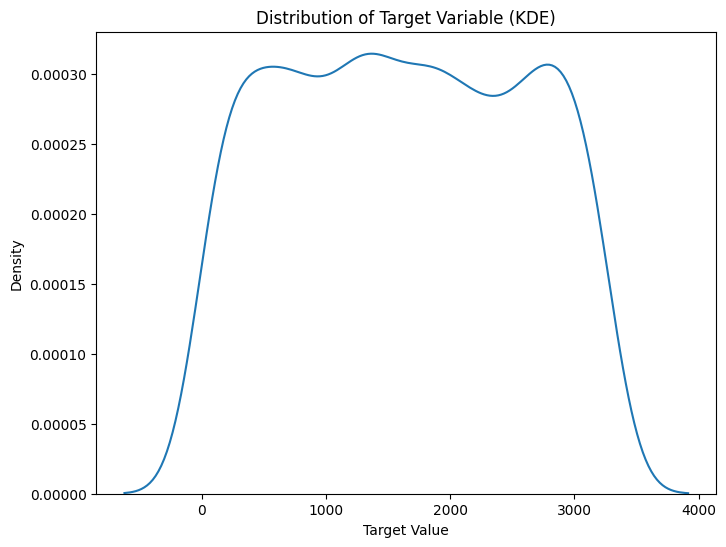

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
plt.hist(df_target['bins'], bins=10)  # Adjust bins as needed
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable (Histogram)')
plt.show()

# 3. KDE plot (сглаженная оценка плотности)
plt.figure(figsize=(8, 6))
sns.kdeplot(df_target['client_id'])
plt.xlabel('Target Value')
plt.ylabel('Density')
plt.title('Distribution of Target Variable (KDE)')
plt.show()

Можно видеть, что небольшой дисбаланас классов наблюдается.

#### 2) Есть ли проблемы с данными по целевой переменной и транзакциям (пропуски/выбросы)?

In [ ]:
source_data.isnull().sum()

,0
client_id,0
trans_date,0
small_group,0
amount_rur,0


In [ ]:
df_target.isnull().sum()

,0
client_id,0
bins,0


Пропусков нет

<Axes: >

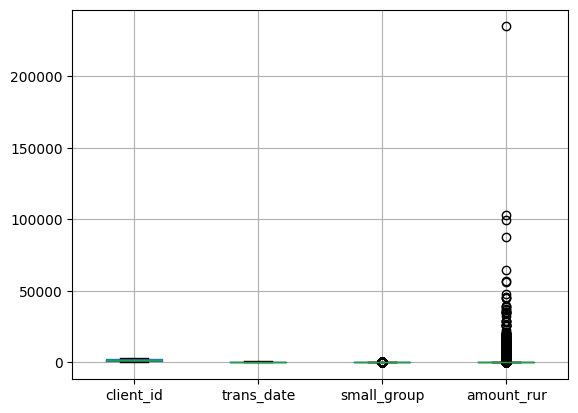

In [ ]:
source_data.boxplot()

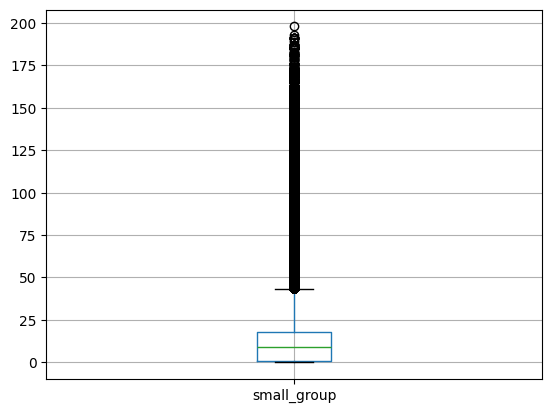

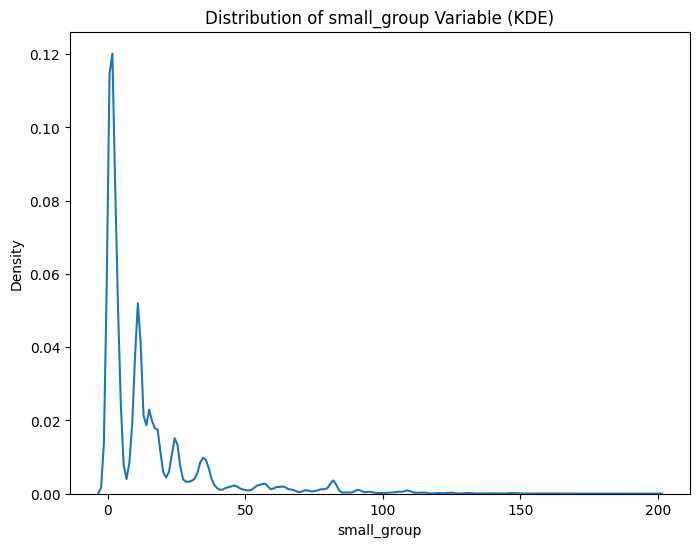

In [ ]:
source_data.boxplot(column=['small_group'])

plt.figure(figsize=(8, 6))
sns.kdeplot(source_data['small_group'])
plt.xlabel('small_group')
plt.ylabel('Density')
plt.title('Distribution of small_group Variable (KDE)')
plt.show()

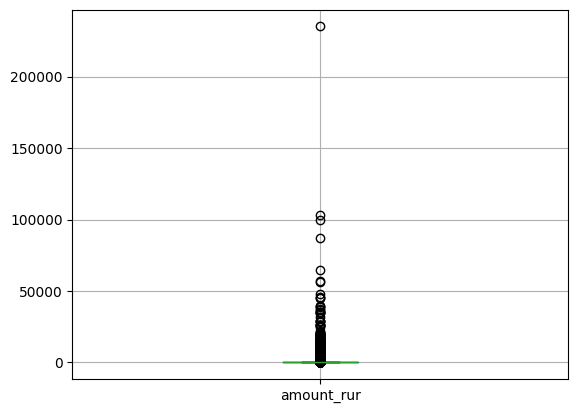

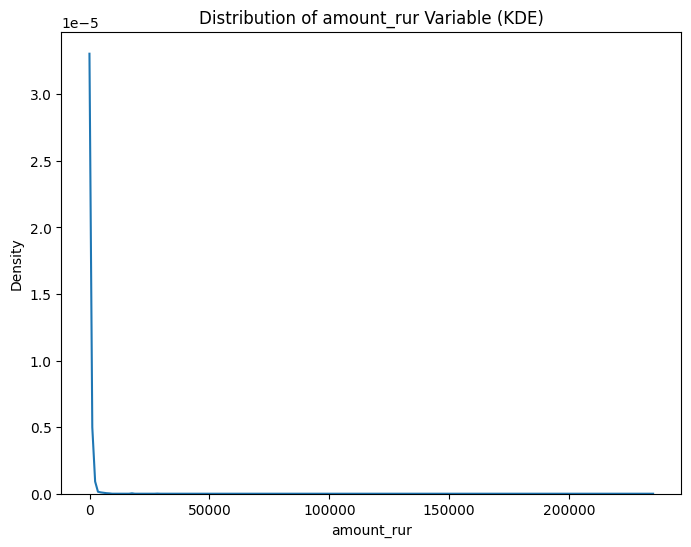

In [ ]:
source_data.boxplot(column=['amount_rur'])

plt.figure(figsize=(8, 6))
sns.kdeplot(source_data['amount_rur'])
plt.xlabel('amount_rur')
plt.ylabel('Density')
plt.title('Distribution of amount_rur Variable (KDE)')
plt.show()

Как можно заметить, в переменных amount_rur и small_group наблюдаются выбросы

#### 3) Нужно ли делать доп. преобразования признаков/таргета для улучшения качества моделирования?

Стоит обрезать выбросы в переменных amount_rur и small_group:

In [ ]:
median_value = source_data['amount_rur'].median()
Q1 = source_data['amount_rur'].quantile(0.05)
Q3 = source_data['amount_rur'].quantile(0.95)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

source_data['amount_rur'] = source_data['amount_rur'].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x) # Замена на медиану вне диапазона

In [ ]:
median_value = source_data['small_group'].median()
Q1 = source_data['small_group'].quantile(0.05)
Q3 = source_data['small_group'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

source_data['small_group'] = source_data['small_group'].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x) # Замена на медиану вне диапазона

### 2.Baseline - **[3 балла]**

На этом этапе формируем "ручные" агрегатные признаки по транзакционным данным и строим на их основе multiclass модели: логистическая регрессия либо градиентный бустинг.

Необходимо сделать __несколько шагов__:

1) Разбить датасет на train и test. Нужно разбить выборки по _client_id_.

2) Cгенерировать "ручные" признаки на основе транзакций (например, количество транзакций, количество транзакций разного типа, средняя/максимальная/минимальная сумма транзакций и тд)

3) Обучить бейзлайн (например, логистическую регрессию или градиентный бустинг) на "ручных" признаках и зафиксировать полученные метрики на test. В качестве ключевых метрик стоит использовать ``accuracy`` и ``f1``.

#### 1) Разбить датасет на train и test. Нужно разбить выборки по client_id.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df = source_data.set_index('client_id').join(df_target.set_index('client_id')).reset_index()

In [ ]:
Y = df['bins']
X = df.drop('bins', axis=1)

In [ ]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)

#### 2) Cгенерировать "ручные" признаки на основе транзакций (например, количество транзакций, количество транзакций разного типа, средняя/максимальная/минимальная сумма транзакций и тд)

In [ ]:
def new_feature(df):
  new_df = pd.DataFrame()

  group_counts_dict = df['small_group'].value_counts().to_dict()
  new_df['small_group_counts'] = df['small_group'].map(group_counts_dict)

  new_df['trans_date_max'] = df['trans_date'].max()
  new_df['trans_date_min'] = df['trans_date'].min()
  new_df['trans_date_mean'] = df['trans_date'].mean()
  new_df['trans_date_median'] = df['trans_date'].median()
  new_df['trans_date_std'] = df['trans_date'].std()


  new_df['amount_rur_max'] = df['amount_rur'].max()
  new_df['amount_rur_min'] = df['amount_rur'].min()
  new_df['amount_rur_mean'] = df['amount_rur'].mean()
  new_df['amount_rur_median'] = df['amount_rur'].median()
  new_df['amount_rur_std'] = df['amount_rur'].std()
  #new_df['client_id'] = df['client_id']

  return new_df

In [ ]:
trainX_new = new_feature(trainX)
testX_new = new_feature(testX)

#### 3) Обучить бейзлайн (например, логистическую регрессию или градиентный бустинг) на "ручных" признаках и зафиксировать полученные метрики на test. В качестве ключевых метрик стоит использовать accuracy и f1.

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(trainX_new, trainY)

pred_lr = lr.predict(testX_new)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

f1_macro = f1_score(testY, pred_lr, average='macro')
print(f"Macro-averaged F1: {f1_macro}")
acc = accuracy_score(testY, pred_lr)
print(f"Accuracy: {acc}")

Macro-averaged F1: 0.1048963177470538
Accuracy: 0.2654906103352865


###  3.Обучение эмбеддингов на транзакциями - **[3 балла]**

На этом этапе нужно сделать __несколько шагов:__

1) Взять разбиение на train и test из шага ```2.Baseline```

2) На train выборке обучить nn для генерации эмбеддингов. Можно поварьировать несколько гиперпараметров обучения.

За основу можно взять несколько примеров:

*    [ноутбук 1](https://github.com/dllllb/pytorch-lifestream/blob/main/tutorials/notebooks/coles-emb.ipynb)
*   [семинарский ноутбук](https://colab.research.google.com/drive/16Cbxx0rNJusIQFfHnYWlkUc58FnUuPyD)

3) Обучить модель (например, логистическую регрессию или градиентный бустинг) на эмбеддингах в качестве признаков и рассчитать метрики ```accuracy``` и ```f1``` на test.

4) Соединить оба подхода генерации признаков ("ручной" из шага ```2.Baseline``` и эмбеддинги из шага ```3.Обучение эмбеддингов на транзакциями```) и рассчитать итоговые метрики.



In [ ]:
!git clone https://github.com/sberbank-ai-lab/pytorch-lifestream/tree/main/dltranz/data_preprocessing.git

Cloning into 'data_preprocessing'...
fatal: repository 'https://github.com/sberbank-ai-lab/pytorch-lifestream/tree/main/dltranz/data_preprocessing.git/' not found


In [ ]:
!git clone https://github.com/sberbank-ai-lab/pytorch-lifestream.git

fatal: destination path 'pytorch-lifestream' already exists and is not an empty directory.


In [ ]:
!pip install -q torchmetrics==0.11.4
!pip install -q pytorch_lightning==1.9.0

import sys
sys.path.append('/content/pytorch-lifestream')

import torchmetrics
torchmetrics.__version__

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import logging
import pytorch_lightning as pl
import warnings

warnings.filterwarnings('ignore')
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

import os
import pandas as pd
import dltranz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from dltranz.data_preprocessing import PandasDataPreprocessor

# подготавливаем данные для обучения модели
preprocessor = PandasDataPreprocessor(
    col_id='client_id',                         #ID клиента (или геометки)
    cols_event_time='trans_date',               #Временная метка
    time_transformation='float',
    cols_category=["trans_date", "small_group"], #Категории транзакций
    cols_log_norm=["amount_rur"],                #Колонки для нормирования
    cols_identity=[],
    print_dataset_info=False,
)

In [149]:
from dltranz.seq_encoder import SequenceEncoder
from dltranz.models import Head
from dltranz.lightning_modules.emb_module import EmbModule

seq_encoder = SequenceEncoder(
    category_features=preprocessor.get_category_sizes(), #категории (например, MCC-коды)
    encoder_type='rnn',                                 #тип энкодера
    numeric_features=["amount_rur"],                     #числовые признаки
    trx_embedding_noize=0.003,
)  #формируем энкодер

head = Head(input_size=seq_encoder.embedding_size, use_norm_encoder=True) # "голова" над энкодером: линейный слой + softmax
model = EmbModule(seq_encoder=seq_encoder, head=head)

In [ ]:
trainX_pr = preprocessor.fit_transform(trainX)
testX_pr = preprocessor.transform(testX)

trainX_pr = sorted(trainX_pr, key=lambda x: x["client_id"])
testX_pr = sorted(testX_pr, key=lambda x: x["client_id"])

In [151]:
from dltranz.data_load.data_module.emb_data_module import EmbeddingTrainDataModule

dm = EmbeddingTrainDataModule(
    dataset=trainX_pr,
    pl_module=model,
    min_seq_len=5,
    seq_split_strategy='SampleSlices',
    category_names = model.seq_encoder.category_names,
    category_max_size = model.seq_encoder.category_max_size,
    split_count=5,
    split_cnt_min=5,
    split_cnt_max=200,
    train_num_workers=16,
    train_batch_size=100,
    valid_num_workers=16,
    valid_batch_size=100
)

In [ ]:
import torch
import pytorch_lightning as pl

trainer = pl.Trainer(
    max_epochs=20,
    gpus=1,
    enable_checkpointing=False
)

In [ ]:
trainer.fit(model, dm)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

INFO:lightning_fabric.accelerators.cuda:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
from dltranz.inference import get_embeddings

train_embeds = get_embeddings(
    data=trainX_pr,
    model=model,
    category_names = model.seq_encoder.category_names,
    category_max_size = model.seq_encoder.category_max_size,
)

test_embeds = get_embeddings(
    data=testX_pr,
    model=model,
    category_names = model.seq_encoder.category_names,
    category_max_size = model.seq_encoder.category_max_size,
)


2000it [00:00, 98537.64it/s]
2000it [00:00, 104113.19it/s]


In [ ]:
df.rename(columns={"bins": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds,
                        columns=[f'embed_{i}' for i in range(train_embeds.shape[1])]
                        )
train_df['client_id'] = [x['client_id'] for x in trainX_pr]
train_df = train_df.merge(df, how='left', on='client_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['client_id'] = [x['client_id'] for x in testX_pr]
test_df = test_df.merge(df, how='left', on='client_id')

In [ ]:
embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target'].values
x_test, y_test = test_df[embed_columns], test_df['target'].values

clf = LogisticRegression()
clf.fit(x_train, y_train)

pred_clf = clf.predict(x_test)

In [ ]:
f1_macro_emb = f1_score(y_test, pred_clf, average='macro')
print(f"Macro-averaged F1: {f1_macro_emb}")
acc_emb = accuracy_score(y_test, pred_clf)
print(f"Accuracy: {acc_emb}")

Macro-averaged F1: 0.28717185929208483
Accuracy: 0.35098082640564915


4) Соединить оба подхода генерации признаков ("ручной" из шага 2.Baseline и эмбеддинги из шага 3.Обучение эмбеддингов на транзакциями) и рассчитать итоговые метрики.

In [ ]:
train_c = train_df.join(trainX_new, how='right')
test_c = test_df.join(testX_new, how='right')

In [ ]:
clf = LogisticRegression()
clf.fit(train_c, trainY)

pred_c = clf.predict(test_c)

In [ ]:
f1_macro_c = f1_score(testY, pred_c, average='macro')
print(f"Macro-averaged F1: {f1_macro_c}")
acc_c = accuracy_score(testY, pred_c)
print(f"Accuracy: {acc_c}")

Macro-averaged F1: 0.30923982479344614
Accuracy: 0.4039099294536124


------------------------------

### 4.Выводы - **[1 балл]**

Выводы должны содержать:



*   Кратко описанные шаги и выводы по ним
*   Метрики, которые удалось достигнуть на этапах 2 и 3
*   Какие "ручные" признаки являются основными для предсказания бакета возраста клиента. Какие гиперпараметры удалось поварьировать для pytorch-lifestream при обучении транзакционных эмбеддингов.



**Выводы:**
1. Проверка на дисбаланс данных: сильного дисбаланаса данных не наблюдается. Поэтому не стоит учитывать веса разных классов в модели
2. Целевая переменная не имеет пропусков как и другие переменные. Выбросы июмет переменные(small_group, amount_rur). Чтобы выбросы не повлияли на предсказание, мы заменим выбросы выше 95% и ниже 5% по нормальному распределению медианой
3. Для модели сформированы ручные признаки: максимальное, минимальное, среднее, медианнное и разброс по trans_date и amount_rur, а также кол-во по каждому small_group
4. Логичтисеская регрессия имеет следующие метрики качества на тесте:
- Macro-averaged F1: 0.1048963177470538
- Accuracy: 0.2654906103352865
5. Были обучены эмбеддинги, которые дали качество на тесте:
- Macro-averaged F1: 0.23106142679979705
- Accuracy: 0.30667102425883647
6. Также были обучены ручные + эмбеддинги признаки, которые дали качество на тесте:
- Macro-averaged F1: 0.309758173987608
- Accuracy: 0.40406002815058584
7. Основными ручными признаками с наибольшей корреляцией c целеовой переменной являются amount_rur_median, amount_rur_std.
Какие гиперпараметры удалось поварьировать для pytorch-lifestream при обучении транзакционных эмбеддингов:
min_seq_len=5, train_batch_size=100,valid_batch_size=100
